In [1]:
import sys
# Assuming you are currently in the 'backtester' directory, 
# you need to go up one level to the 'project_folder' and then into 'TestFolder'
sys.path.append('../') 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Callable

# Now you can import Strat1
from Alphas.strat1 import Strat1
from Alphas.strat2 import Strat2
from Alphas.stratwithparam import StratWithParam
from quantutils.backtester_utils import calc_stats, main_backtester
from Alphas.mainalpha import Alpha
from itertools import product, combinations, permutations
from Alphas.alphaminer import AlphaMiner, generate_param_combinations_and_multi_index

%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(22)
contract_size = pd.Series([25, 1, 5, 3, 10])
T = 5000
df_ret = pd.DataFrame(np.random.normal(loc=0.001, scale=0.02, size=(T, 5)))
df_ret.index = pd.date_range('2010-01-01', periods=T)
df_ret = df_ret *np.array([1.0, 1.5, 3.0, 0.2, 2.0]) + 1
df_ret.iloc[0] = [1, 10, 20, 8, 30]
df_ret
df_price =  (df_ret).cumprod()
### df_dict
attributes = ['high', 'close', 'low', 'max', 'trend']
df_dict = {}

for attribute in attributes:
    window = np.random.randint(5, 101)
    df_signal = (df_price.pct_change(window).shift(-window+1) + np.random.normal(scale=0.5, size=df_ret.shape)).shift().ffill().bfill() * 100
    df_signal = df_signal.rolling(20).mean()

    df_signal = df_signal/df_signal.std()
    df_dict[attribute] = df_signal
    
df_dict['price'] = df_price
df_dict['low'] = df_dict['low'].drop(0 ,axis=1)
contract_size = {k : np.random.randint(1, 20) for k in range(df_ret.shape[1])}


In [4]:

strat2 = Strat2(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat2.run_backtest()
start = '2010-01-01'
end = '2013-01-01'
shift_signal = 2
pre_compute_params = {'attribute': 'high'}
post_compute_params = {'rolling_window': 10, 'mult': 0.02}
strat3 = StratWithParam(df_dict, start, end, 1_000_000, contract_size, shift_signal,
                        pre_compute_params, post_compute_params)

strat3.run_backtest()
strat3.df_pnl_nominal

,0,1,2,3,4
2010-02-04,35423.768295,-66491.274889,-67834.574080,31377.769435,308341.401530
2010-02-05,-5011.525203,54411.525227,448704.283924,3625.553291,-54401.964833
2010-02-06,198363.456989,-20675.601067,-131314.381247,24658.777326,-137840.630789
2010-02-07,45470.243967,22838.079958,-7962.202106,17265.875456,211170.398272
2010-02-08,77674.694669,-47627.639010,46728.230547,-13920.990410,79091.294709
...,...,...,...,...,...
2012-12-30,2081.193630,6.793345,-79796.379993,2107.554182,-1930.144028
2012-12-31,14162.354489,-11.472801,75429.691963,-1190.996616,5497.005794
2013-01-01,5263.526970,-22.398290,28858.230758,-532.562267,-7196.823444
2013-01-02,-856.132764,-1970.929716,44632.364526,431.450303,11536.784309


In [6]:
import time

    
pre_compute_params_mega = {'attribute': ['high', 'low', 'trend', 'max']}
post_compute_params_mega = {'rolling_window': np.random.randint(2, 50, 10), 'mult': [0.1, 0.2, 0.3, 0.4]}    
combinations, multiindex = generate_param_combinations_and_multi_index(pre_compute_params_mega, post_compute_params_mega)
start = '2010-01-01'
end = '2023-01-01'
strat_skeleton = StratWithParam(df_dict, start, end, 1_000_000, contract_size, 2)
alphaminer = AlphaMiner(strat_skeleton, pre_compute_params_mega, post_compute_params_mega)
(alphaminer.parameters_mining())


Number Of Combinations: 160
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.4})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.4})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.4})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.4})


In [5]:
groupings = {'EM': [0, 1, 2, 6, 7], 'DM': [3]}
alpha1 = Strat1(df_dict, start, end, 1_000_000, contract_size, 2)
alpha1.pnl_decomposition(groupings=groupings, cost_list=[0, 0.01, 0.001, 0.0001])
alpha1.run_robustness_tests(10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:

def plot(alpha):
    # sns.set(style='darkgrid')
    fig, axes = plt.subplots(6, 2, figsize=(20, 35))
    
    
    ## Row 0
    
    alpha.df_pnl_capital.sum(axis=1).cumsum().plot(ax=axes[0][0], color='blue', linewidth=3)
    alpha.df_pnl_capital_long_short.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[0][0], color=['green', 'red'])
    axes[0][0].legend(['PnL (left)', 'Long PnL (left)', 'Short PnL (left)'])
    axes[0][0].set_title('PnL')
    alpha.df_pnl_capital.cumsum().plot(ax=axes[0][0], color='gray', legend=False, secondary_y=True)
    alpha.df_pnl_by_group.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[0][1])
    axes[0][1].legend(bbox_to_anchor=[1.2, 0.8])
    axes[0][1].set_title('PnL by group')
    
    ## Row 1 
    alpha.df_pnl_with_tc.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[1][0], title='PnL with TC')
    
    axes[1][1].axis('off')
    stats_with_tc_table = axes[1][1].table(cellText=alpha.df_stats_with_tc.round(3).T.values, colLabels=alpha.df_stats_with_tc.T.columns, loc='center')
    stats_with_tc_table.auto_set_font_size(False)
    stats_with_tc_table.set_fontsize(10)
    stats_with_tc_table.scale(1, 2) 
    
    
    
    ## Row 2
    alpha.df_weights.plot(ax=axes[2][0])    
    axes[2][0].legend(bbox_to_anchor=[1.2, 0.8])
    axes[2][0].set_title('Weights in Percentage')
    alpha.df_weights_by_group.groupby(level=0, axis=1).sum().plot(ax=axes[2][1])
    axes[2][1].legend(bbox_to_anchor=[1.2, 0.8])
    axes[2][1].set_title('Weights by group in percentage')
    
    ## Row 3
    
    alpha.df_nominal.abs().sum(axis=1).plot(ax=axes[3][0], title='PnL in Nominal')
    alpha.df_pnl_nominal.sum(axis=1).fillna(0).rolling(25, min_periods=25).std().mul(np.sqrt(252)).plot(ax=axes[3][1], title='Rolling 1y Dollar Nominal Vol')
    
    ## Row 4
    stats = calc_stats(alpha.df_pnl_capital)
    
    sns.histplot(alpha.df_robustness_stats['Cross-Section']['sharpe'], color='skyblue', kde=True, label='Cross-Section', ax=axes[4][0])
    sns.histplot(alpha.df_robustness_stats['Time-Series']['sharpe'], color='green', label='Time-Series', kde=True, ax=axes[4][0])
    sns.histplot(alpha.df_robustness_stats['Both']['sharpe'], color='orange', label='Both', kde=True, ax=axes[4][0])

    axes[4][0].axvline(x=stats['sharpe'], color='red', linestyle='--')
    axes[4][0].legend(bbox_to_anchor=[1.2, 0.8])
    axes[4][0].set_title('Robustness Test')
    rolling_sharpe_1y = alpha.df_pnl_capital.sum(axis=1).rolling(252).mean()/alpha.df_pnl_capital.sum(axis=1).rolling(252).std() * np.sqrt(252)
    rolling_sharpe_3y = alpha.df_pnl_capital.sum(axis=1).rolling(252*3).mean()/alpha.df_pnl_capital.sum(axis=1).rolling(252*3).std() * np.sqrt(252)
    
    rolling_sharpe_1y.plot(ax=axes[4][1])
    rolling_sharpe_3y.plot(ax=axes[4][1])
    axes[4][1].legend(['1y', '3y'], bbox_to_anchor=[1.2, 0.8])
    axes[4][1].set_title('Rolling Sharpe')
    
    ## Row 5
    drawdown = (alpha.df_pnl_capital.sum(axis=1).cumsum().cummax() - alpha.df_pnl_capital.sum(axis=1).cumsum())*(-1)
    drawdown.plot(ax=axes[5][0], title='Drawdown', color='red')
    
    fig.tight_layout()

    plt.show()
    


C:\Users\Wazir\AppData\Local\Temp\ipykernel_28520\3830508784.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  alpha.df_pnl_capital_long_short.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[0][0], color=['green', 'red'])
C:\Users\Wazir\AppData\Local\Temp\ipykernel_28520\3830508784.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  alpha.df_pnl_by_group.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[0][1])
C:\Users\Wazir\AppData\Local\Temp\ipykernel_28520\3830508784.py:18: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  alpha.df_pnl_with_tc.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[1][0], title='PnL with TC')
C:\Users\Wazir\AppData\Local\Temp\ipykernel_28520\3830508784.py:32: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis 

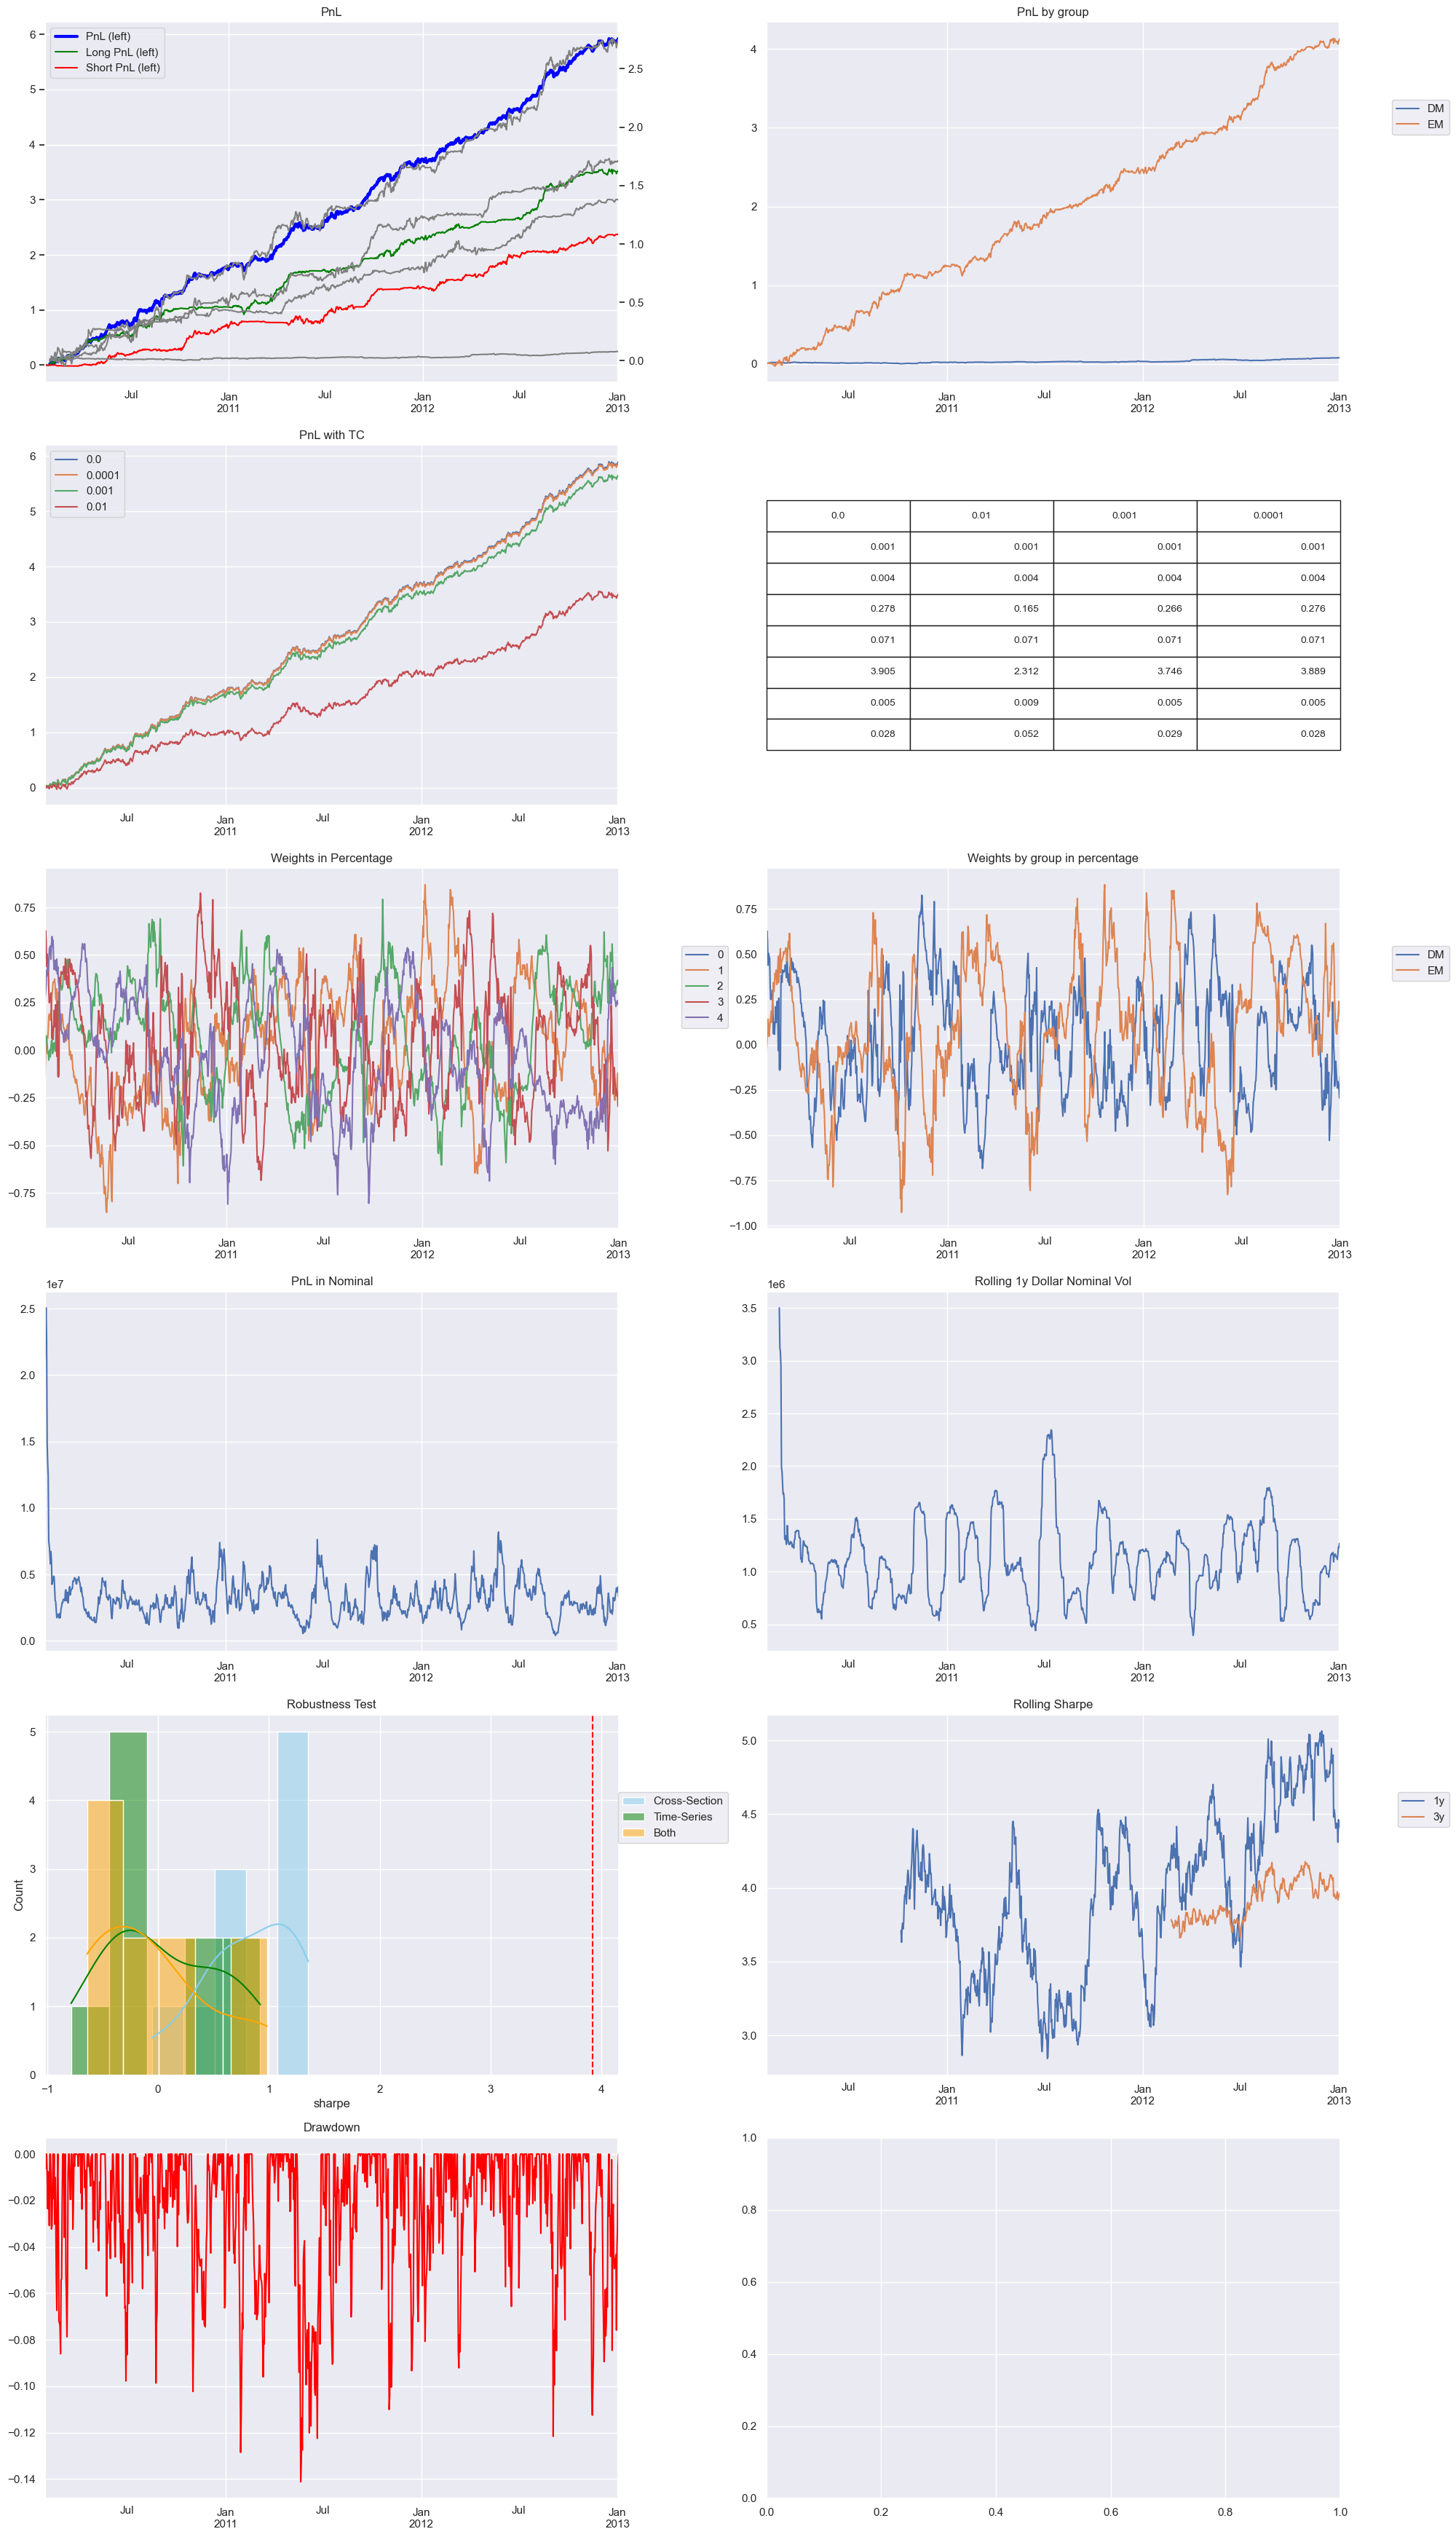

In [9]:
plot(alpha1)